# SEC61A1
SEC61 complex, alpha-1 subunit (SEC61A1), is a subunit of the heteromeric SEC61 complex, which also contains beta (SEC61B; 609214) and gamma (SEC61G; 609215) subunits. The SEC61 complex forms the core of the mammalian endoplasmic reticulum (ER) translocon (See [OMIM:609213]). Pathogenic variants in SEC61A1 are associated with
[Neutropenia, severe congenital, 11, autosomal dominant (OMIM:620674)](https://omim.org/entry/620674),
[Immunodeficiency, common variable, 15 (OMIM:620670)](https://omim.org/entry/620670), and
[Tubulointerstitial kidney disease, autosomal dominant, 5 (OMIM:617056)](https://omim.org/entry/617056).

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'SEC61A1'
mane_tx_id = 'NM_013336.4'
mane_protein_id = 'NP_037468.1' # protein transport protein Sec61 subunit alpha isoform 1 isoform 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.24'  
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    cdls6_phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator   = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=cdls6_phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 19/19 [00:00<00:00, 548.48 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
10,Decreased circulating IgG concentration
10,Decreased specific antibody response to protein-conjugated polysaccharide vaccine
9,Decreased specific antibody response to polysaccharide vaccine
8,Decreased circulating IgA concentration
7,Decreased circulating total IgM
7,Small for gestational age
7,Elevated circulating creatinine concentration
7,Anemia
7,Recurrent otitis media
5,Chronic kidney disease


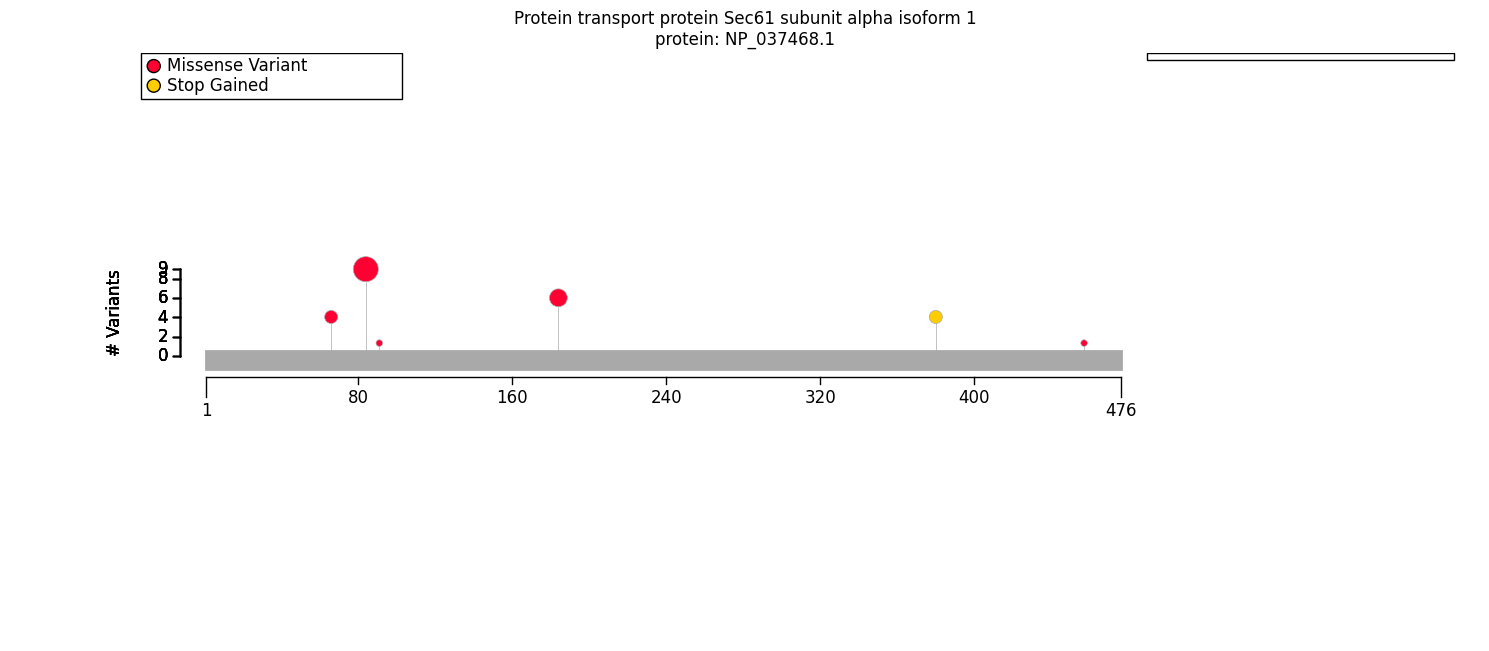

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

sec61a1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
sec61a1_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import monoallelic_classifier

val85asp = variant_key("3_128056742_128056742_T_A") # p.Val85Asp
val85asp_clf = monoallelic_classifier(
    a_predicate=val85asp,
    b_predicate= ~val85asp,
    a_label='p.Val85Asp', 
    b_label='Other variant'
)
val85asp_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=val85asp_clf,
    pheno_clfs=pheno_clfs,
)
viewer = MtcStatsViewer()
viewer.process(val85asp_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,25
HMF03,Skipping term because of a child term with the same individual counts,3
HMF05,Skipping term because one genotype had zero observations,6
HMF08,Skipping general term,76
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,143


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=val85asp_result)

Allele group,p.Val85Asp,Other variant,Corrected p values,p values
Recurrent lower respiratory tract infections [HP:0002783],6/6 (100%),0/5 (0%),0.038961,0.002165
Elevated circulating creatinine concentration [HP:0003259],0/4 (0%),7/8 (88%),0.060606,0.010101
Anemia [HP:0001903],0/4 (0%),7/8 (88%),0.060606,0.010101
Recurrent respiratory infections [HP:0002205],6/6 (100%),1/6 (17%),0.065455,0.015152
Decreased circulating IgA concentration [HP:0002720],8/9 (89%),0/3 (0%),0.065455,0.018182
Recurrent infections [HP:0002719],8/8 (100%),5/10 (50%),0.102273,0.035948
Decreased circulating total IgM [HP:0002850],7/9 (78%),0/3 (0%),0.102273,0.045455
Decreased circulating IgG concentration [HP:0004315],9/9 (100%),1/3 (33%),0.102273,0.045455
Recurrent upper respiratory tract infections [HP:0002788],2/2 (100%),1/6 (17%),0.214286,0.107143
Recurrent otitis media [HP:0000403],4/9 (44%),3/8 (38%),1.000000,1.000000


In [9]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Decreased circulating IgA concentration [HP:0002720],1/4 (25%),7/8 (88%),0.977941,0.066667
Decreased circulating IgG concentration [HP:0004315],2/4 (50%),8/8 (100%),0.977941,0.090909
Decreased circulating total IgM [HP:0002850],1/4 (25%),6/8 (75%),0.977941,0.222222
Recurrent lower respiratory tract infections [HP:0002783],1/4 (25%),5/7 (71%),0.977941,0.242424
Decreased specific antibody response to protein-conjugated polysaccharide vaccine [HP:0410302],2/3 (67%),8/8 (100%),0.977941,0.272727
Elevated circulating creatinine concentration [HP:0003259],4/5 (80%),3/7 (43%),0.977941,0.292929
Anemia [HP:0001903],4/5 (80%),3/7 (43%),0.977941,0.292929
Recurrent infections [HP:0002719],4/7 (57%),9/11 (82%),0.977941,0.325980
Hyperuricemia [HP:0002149],4/5 (80%),1/3 (33%),1.000000,0.464286
Recurrent respiratory infections [HP:0002205],2/5 (40%),5/7 (71%),1.000000,0.558081


# Summary

In [10]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=val85asp_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = """The origin of clinical diversity in patients with SEC61A1 mutation is currently unclear. 
With our present patient set, a particular phenotype cannot be predicted on the basis of location or nature of the mutation \\cite{PMID_32325141}.
"""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [11]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [12]:
summarizer.process_latex(report=report, protein_fig=sec61a1_fig)

Figure saved to ../../supplement/img/SEC61A1_protein_diagram-draft.pdf
Output to ../../supplement/tex/SEC61A1_summary_draft.tex
